In [2]:
%%time
from pycolator import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank', 'temp_score', 'percolator_score']

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)
features = [x for x in list(dSlow.columns) if (x not in excluded)]

file read...
strings converted to numbers...
q-values estimated...
ranks computed...
features normed...
file ready!
Wall time: 13.5 s


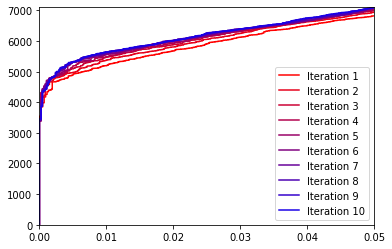

Number of PSMs for q <= 0.01, rank = 1, training with rank 1 only = True and classes option = : 
5569


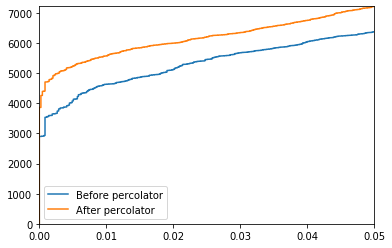

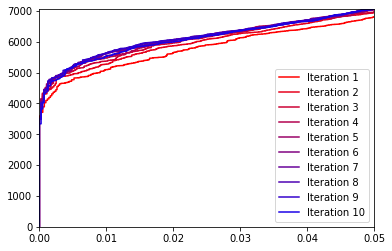

Number of PSMs for q <= 0.01, rank = 1, training with rank 1 only = True and classes option = balanced: 
5560


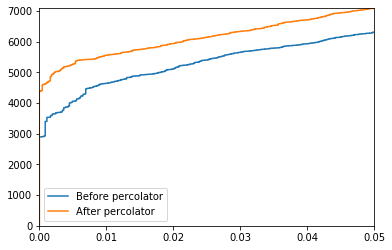

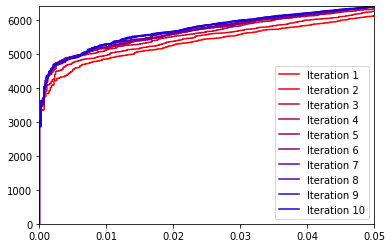

Number of PSMs for q <= 0.01, rank = 1, training with rank 1 only = False and classes option = : 
5351


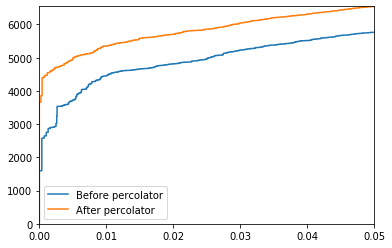

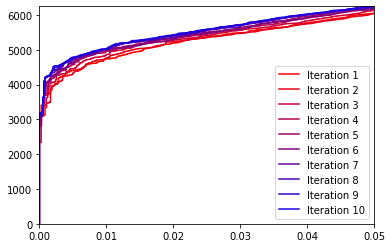

Number of PSMs for q <= 0.01, rank = 1, training with rank 1 only = False and classes option = balanced: 
5185


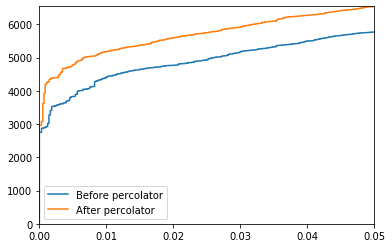

In [2]:
# evaluate using only rank 1 or not and using class option 'balanced' or not
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'Rank']

for rankOneOnly in [True, False]:
    for classesOption in ['', 'balanced']:
        
        # generate iterations plot
        p = percolator(dSlow, 'SpecId', excluded, useRankOneOnly = rankOneOnly, plotEveryIter = True, suppressLog = True,
                       class_weight = classesOption,
                       plotSaveName = '../results/percolator1_rankOneOnly={r}_ClassesOption={c}.png'.format(r = str(rankOneOnly),
                                                                                                            c = classesOption))
        
        # calc number of PSMs for q <= 0.01
        num = len(p[(p['q-val'] <= 0.01) & (p['Rank'] == 1)])
        print('Number of PSMs for q <= 0.01, rank = 1, training with rank 1 only = {r} and classes option = {c}: '.format(r = str(rankOneOnly), c = classesOption))
        print(num)
        
        # compare with NuXL:score
        pseudoROC(calcQ(p, 'NuXL:score'), 0.05, label = 'Before percolator')
        pseudoROC(calcQ(p, 'percolator_score'), 0.05, label = 'After percolator')
        plt.legend(loc='best')
        plt.savefig('../results/percolator2_rankOneOnly={r}_ClassesOption={c}.png'.format(r = str(rankOneOnly), c = classesOption))
        plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


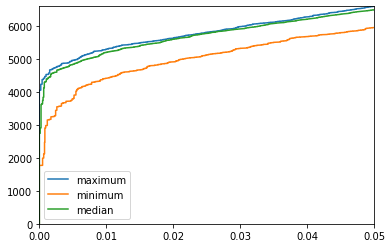

class Option: , max PSMs: 5285, min PSMs: 4413, median PSMs: 5203.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


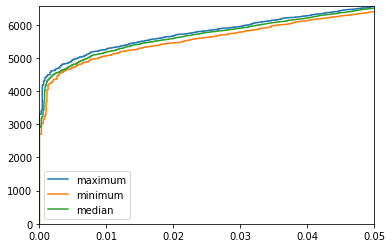

class Option: balanced, max PSMs: 5261, min PSMs: 5067, median PSMs: 5179.0


In [4]:
# evaluate different class options 10 times each
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'Rank']
for classOption in ['','balanced']:
    qVals = []
    PSMs = []
    for i in range(10):
        p = percolator(dSlow, 'SpecId', excluded, suppressLog = True, class_weight = classOption)

        # calc number of PSMs for q <= 0.01
        num = len(p[(p['q-val'] <= 0.01) & (p['Rank'] == 1)])
        PSMs.append(num)
        
        qVals.append(p.loc[p['Rank'] == 1,'q-val'].tolist())
    pseudoROCmulti(qVals)
    plt.savefig('../results/percolator_MaxMinMedian_ClassesOption={c}.png'.format(c = classOption))
    plt.show()
    print('class Option: {}, max PSMs: {}, min PSMs: {}, median PSMs: {}'.format(classOption, max(PSMs), min(PSMs), np.median(PSMs)))

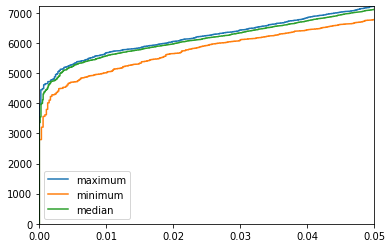

rank option: True, max PSMs: 5669, min PSMs: 5011, median PSMs: 5569.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


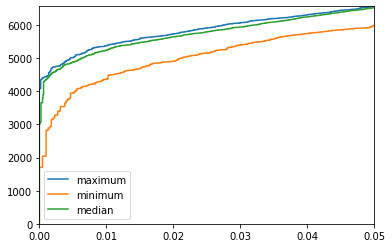

rank option: False, max PSMs: 5380, min PSMs: 4364, median PSMs: 5238.0


In [2]:
# evaluate different rank options 10 times each
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'Rank']
for useRankOne in [True, False]:
    qVals = []
    PSMs = []
    for i in range(10):
        p = percolator(dSlow, idCol, excluded, suppressLog = True, useRankOneOnly = useRankOne)

        # calc number of PSMs for q <= 0.01
        num = len(p[(p['q-val'] <= 0.01) & (p['Rank'] == 1)])
        PSMs.append(num)
        
        qVals.append(p[p['Rank'] == 1]['q-val'].tolist())
    pseudoROCmulti(qVals)
    plt.savefig('../results/percolator_MaxMinMedian_RankOption={}'.format(useRankOne))
    plt.show()
    print('rank option: {}, max PSMs: {}, min PSMs: {}, median PSMs: {}'.format(useRankOne,
                                                                                max(PSMs), min(PSMs), np.median(PSMs)))

In [4]:
%%time

# evaluate percolator with and without balancing
for balance in [True, False]:
    qVals = []
    AUCs = []
    for _ in range(10):
        p = percolator_experimental(dSlow, idCol, features, suppressLog = True, propTarDec = balance, propXLnXL = balance, 
                       balancingInner = balance, balancingOuter = balance)

        # calc AUC
        num = [pseudoROC(p,plot = False)] + evalXL(p,plot = False)
        AUCs.append(num)
        
        qVals.append(p.loc[p.Rank == 1, 'q-val'].tolist())
    pseudoROCmulti(qVals)
    plt.savefig('../results/percolator_acv_MaxMinMedian_balancing={}'.format(balance))
    plt.show()
    fullAUC = [a[0] for a in AUCs]
    maxI = np.argmax(fullAUC)
    minI = np.argmin(fullAUC)
    print('used balancing: {}, max AUCs: {}, min AUCs: {}, median AUCs: {}'.format(balance,
                                                                                   AUCs[np.argmax], AUCs[np.argmin], np.median(fullAUC)))

KeyboardInterrupt: 

In [5]:
np.argmax([1,4,3])

1